In [1]:
import numpy as np
import pickle
from copy import deepcopy
from itertools import chain
from collections import OrderedDict
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300
from IPython.display import display, HTML
import sys, os
sys.path.append(os.path.join(os.path.dirname("__file__"), '..', '..', '..'))
from AI_scientist.prepare_dataset import Dataset_Gen
from AI_scientist.util import plot_matrices, make_dir, get_struct_str, get_args, Early_Stopping, record_data, manifold_embedding, get_args, make_dir, sort_two_lists, get_highlight_fun
from AI_scientist.settings.filepath import variational_model_PATH, dataset_PATH
from AI_scientist.settings.global_param import COLOR_LIST
from AI_scientist.pytorch.net import Net, load_model_dict_net
from AI_scientist.pytorch.util_pytorch import to_Variable, to_np_array
from AI_scientist.variational.util_variational import sort_datapoints, get_torch_tasks, reshape_time_series
from AI_scientist.variational.variational_meta_learning import Master_Model, Statistics_Net, Generative_Net, load_model_dict, plot_quick_learn_performance, quick_learn, predict_forward
from AI_scientist.variational.variational_meta_learning import VAE_Loss, sample_Gaussian, clone_net, get_nets, get_tasks, evaluate, get_reg, load_trained_models, get_relevance
from AI_scientist.variational.variational_meta_learning import plot_task_ensembles, plot_individual_tasks, plot_statistics_vs_z, plot_data_record, get_forward_pred
from AI_scientist.variational.variational_meta_learning import plot_few_shot_loss, plot_individual_tasks_bounce
from AI_scientist.variational.variational_meta_learning import get_latent_model_data, get_polynomial_class, get_Legendre_class, get_master_function
import torch
import torch.nn as nn
from torch.autograd import Variable

is_cuda = torch.cuda.is_available()

In [2]:
def plot_quick_learn_curve(mse_list_all, num_tasks_test):
    plt.figure(figsize = (8,6))
    mse_list_all = np.array(mse_list_all)
    if not np.any(np.isnan(mse_list_all)):
        mse_mean = mse_list_all.mean(0)
        mse_std = mse_list_all.std(0)

        plt.fill_between(range(len(mse_mean)), mse_mean - mse_std * 1.96 / np.sqrt(int(num_tasks_test / 100)), mse_mean + mse_std * 1.96 / np.sqrt(num_tasks_test / 100), alpha = 0.3)
        plt.plot(range(len(mse_mean)), mse_mean)
        plt.title("few-shot regression", fontsize = 20)
        plt.xlabel("Number of gradient steps", fontsize = 18)
        plt.ylabel("Mean Squared Error", fontsize = 18)
        plt.show()
    else:
        print("NaN encouncered!")

def parse_dict(filename):
    filename_split = filename.split("_")
    data_dict = {}
    filename_split = filename.split("_")
    data_dict["exp_mode"] = filename_split[1]
    data_dict["task_id"] = eval(filename_split[2])[0]
    data_dict["input_size"] = filename_split[filename_split.index("input") + 1]
    data_dict["statistics_output_neurons"] = filename_split[filename_split.index("stat") + 1]
    data_dict["pre_pooling_neurons"] = filename_split[filename_split.index("pre") + 1]
    data_dict["num_context_neurons"] = filename_split[filename_split.index("context") + 1]
    data_dict["statistics_pooling"] = filename_split[filename_split.index("pool") + 1]
#     data_dict["batch_size_task"] = filename_split[filename_split.index("batch") + 1]
#     data_dict["num_backwards"] = filename_split[filename_split.index("back") + 1]
    if "hid" in filename_split:
        data_dict["main_hidden_neurons"] = eval(filename_split[filename_split.index("hid") + 1])
        data_dict["struct_param_pre_neurons"] = eval(filename_split[filename_split.index("hid") + 2])
        data_dict["struct_param_gen_base_neurons"] = eval(filename_split[filename_split.index("hid") + 3])
    data_dict["is_VAE"] = eval(filename_split[filename_split.index("VAE") + 1])
    data_dict["VAE_beta"] = filename_split[filename_split.index("VAE") + 2]
    data_dict["lr"] = filename_split[filename_split.index("lr") + 1]
    data_dict["reg_amp"] = filename_split[filename_split.index("reg") + 1]
    data_dict["activation_gen"] = filename_split[filename_split.index("actgen") + 1]
    data_dict["activation_model"] = filename_split[filename_split.index("actmodel") + 1]
    if "struct" in filename_split:
        data_dict["struct_string"] = filename_split[filename_split.index("struct") + 1]
    data_dict["loss_core"] = filename_split[filename_split.index("core") + 1]
    data_dict["main_hidden_neurons"] = eval(filename_split[filename_split.index("hid") + 1])
    if "uncer" in filename_split:
        data_dict["is_uncertainty"] = eval(filename_split[filename_split.index("uncer") + 1])
    optim_mode = filename_split[filename_split.index("core") - 1]
    if optim_mode in ["sum", "indi"]:
        data_dict["optim_mode"] = optim_mode
    if "pat" in filename_split:
        data_dict["patience"] = int(filename_split[filename_split.index("pat") + 1])
    if "for" in filename_split:
        data_dict["forward_steps"] = eval(filename_split[filename_split.index("for") + 1])
    data_dict["exp_id"] = filename_split[-1]
    data_dict["filename"] = filename
    return data_dict


def load_file(exp_id, filename):
    dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
    info_dict = pickle.load(open(dirname + filename, "rb"))
    data_record = info_dict["data_record"]
    data_dict = parse_dict(filename)
    master_model = load_model_dict(info_dict["model_dict"][-1])
    print("\n{0}".format(filename))

    data_dict["mse_few_shot"] = plot_few_shot_loss(master_model, tasks_test)
    plot_data_record(info_dict["data_record"], is_VAE = is_VAE)
    data_dict["mean_last"] = np.mean(data_record['mse_mean_test'][-6:-1])
    data_dict["median_last"] = np.mean(data_record['mse_median_test'][-6:-1])
    data_dict["mean_min"] = np.min(data_record['mse_mean_test'])
    data_dict["median_min"] = np.min(data_record['mse_median_test'])
    print("mean_last: {0:6f}\tmean_min: {1:.6f}\tmedian_last: {2:.6f}\tmedian_min: {3:.6f}".format(data_dict["mean_last"], data_dict["mean_min"], data_dict["median_last"], data_dict["median_min"]))
    statistics_list_test, z_list_test = plot_task_ensembles(tasks_test, master_model.statistics_Net, master_model.generative_Net, is_VAE = is_VAE, title = "y_pred_test vs. y_test")
    print("test statistics vs. z:")
    data_dict["corr_info"] = plot_statistics_vs_z(z_list_test, statistics_list_test)
    if "bounce" in task_id_list[0]:
        plot_individual_tasks_bounce(tasks_test, num_examples_show = 40, num_tasks_show = 9, master_model = master_model, num_shots = 200)
    else:
        _ = plot_individual_tasks(tasks_test, master_model.statistics_Net, master_model.generative_Net, is_VAE = is_VAE, xlim = task_settings["xlim"])
    return master_model, info_dict, data_dict


# See the general performance of all
def load_df(exp_id, task_id, exp_mode, num_test_tasks, min_shots = None, isplot = True):
    task_id_list = [task_id]
    is_oracle = (exp_mode == "oracle")
    dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
    data_dict_list = []
    i = 0
    is_time_series = True if "bounce" in task_id else False
    for filename in os.listdir(dirname):
        if "info" not in filename:
            continue
        try:
            info_dict = pickle.load(open(dirname + filename, "rb"))
        except:
            print("Cannot load {0}".format(filename))
        data_record = info_dict["data_record"]
        data_dict = parse_dict(filename)
        if task_id is not None:
            if task_id != data_dict["task_id"]:
                continue
        if exp_mode != data_dict["exp_mode"]:
            continue
        if data_dict["exp_mode"] == "meta": 
            master_model = load_model_dict(info_dict["model_dict"][-1])
            model = None
            data_dict["mse_few_shot"] = plot_few_shot_loss(model, tasks_test, min_shots = min_shots)
        elif data_dict["exp_mode"] in ["finetune", "baseline", "oracle"]:
            print(filename)
            model = load_model_dict_net(info_dict["model_dict"][-1])
            master_model = None
            data_dict["mse_few_shot"] = [None]
        print("\n{0}\t{1}".format(i, filename))

        if isplot:
            plot_data_record(info_dict["data_record"], is_VAE = data_dict["is_VAE"])
        data_dict["mean_last"] = np.mean(data_record['mse_mean_test'][-4:-1])
        data_dict["median_last"] = np.mean(data_record['mse_median_test'][-4:-1])
        data_dict["mean_min"] = np.min(data_record['mse_mean_test'])
        data_dict["median_min"] = np.min(data_record['mse_median_test'])
        if "mse_test" in info_dict or "mse_test_lr_0.001" in info_dict:
            try:
                data_dict["mse_test"] = info_dict["mse_test"]
            except:
                data_dict["mse_test"] = info_dict["mse_test_lr_0.001"]
            mse_mean = np.array(data_dict["mse_test"]).mean(0)
            data_dict["mse_test_0"] = mse_mean[0]
            data_dict["mse_test_5"] = mse_mean[5]
            data_dict["mse_test_10"] = mse_mean[10]
            data_dict["mse_test_20"] = mse_mean[20]
            if isplot:
                plot_quick_learn_curve(data_dict["mse_test"], num_test_tasks, is_time_series = is_time_series)
        print("mean_last: {0:6f}\tmean_min: {1:.6f}\tmedian_last: {2:.6f}\tmedian_min: {3:.6f}".format(data_dict["mean_last"], data_dict["mean_min"], data_dict["median_last"], data_dict["median_min"]))
        if data_dict["exp_mode"] == "meta": 
            statistics_list_test, z_list_test = plot_task_ensembles(tasks_test, master_model = master_model, model = model, is_time_series = is_time_series, is_VAE = data_dict["is_VAE"], title = "y_pred_test vs. y_test", isplot = isplot)
            print("test statistics vs. z:")
            if isplot:
                data_dict["corr_info"] = plot_statistics_vs_z(z_list_test, statistics_list_test)
        if isplot:
            if "bounce" in task_id_list[0]:
                if data_dict["exp_mode"] == "meta": 
                    plot_individual_tasks_bounce(tasks_test, num_examples_show = 40, num_tasks_show = 9, is_time_series = is_time_series, master_model = master_model, model = model, num_shots = 200)
                elif data_dict["exp_mode"] == "baseline":
                    plot_individual_tasks_bounce(tasks_test, num_examples_show = 40, num_tasks_show = 9, is_time_series = is_time_series, master_model = master_model, model = model, num_shots = 200)
            else:
                _ = plot_individual_tasks(tasks_test, master_model = master_model, model = model, is_time_series = is_time_series, is_VAE = data_dict["is_VAE"], is_oracle = is_oracle, xlim = (-5, 5))
        data_dict_list.append(data_dict)
        i += 1
    df = pd.DataFrame(data_dict_list)
    df = df.sort_values(by = "median_last")
    return df


def visualize_file(filename, exp_id, task_id, exp_mode, num_test_tasks, min_shots = 100, num_examples_show = 15, target_forward_steps = 1, eval_forward_steps = 1, isplot = True):
    task_id_list = [task_id]
    dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
    try:
        info_dict = pickle.load(open(dirname + filename, "rb"))
    except:
        raise
        print("Cannot load {0}".format(filename))
    data_record = info_dict["data_record"]
    data_dict = parse_dict(filename)
    if data_dict["exp_mode"] == "meta": 
        master_model = load_model_dict(info_dict["model_dict"][-1])
        model = None
        data_dict["mse_few_shot"] = plot_few_shot_loss(model, tasks_test, min_shots = min_shots)
    elif data_dict["exp_mode"] in ["finetune", "baseline", "oracle"]:
        print(filename)
        model = load_model_dict_net(info_dict["model_dict"][-1])
        master_model = None
        data_dict["mse_few_shot"] = [None]
    print("\n{0}\t{1}".format(i, filename))

    if isplot:
        plot_data_record(info_dict["data_record"], is_VAE = data_dict["is_VAE"])
    data_dict["mean_last"] = np.mean(data_record['mse_mean_test'][-4:-1])
    data_dict["median_last"] = np.mean(data_record['mse_median_test'][-4:-1])
    data_dict["mean_min"] = np.min(data_record['mse_mean_test'])
    data_dict["median_min"] = np.min(data_record['mse_median_test'])
    if "mse_test" in info_dict:
        data_dict["mse_test"] = info_dict["mse_test"]
        mse_mean = np.array(info_dict["mse_test"]).mean(0)
        data_dict["mse_test_0"] = mse_mean[0]
        data_dict["mse_test_5"] = mse_mean[5]
        data_dict["mse_test_10"] = mse_mean[10]
        data_dict["mse_test_20"] = mse_mean[20]
        if isplot:
            plot_quick_learn_curve(data_dict["mse_test"], num_test_tasks)
    print("mean_last: {0:6f}\tmean_min: {1:.6f}\tmedian_last: {2:.6f}\tmedian_min: {3:.6f}".format(data_dict["mean_last"], data_dict["mean_min"], data_dict["median_last"], data_dict["median_min"]))
    if data_dict["exp_mode"] == "meta": 
        statistics_list_test, z_list_test = plot_task_ensembles(tasks_test, master_model = master_model, model = model, is_VAE = data_dict["is_VAE"], title = "y_pred_test vs. y_test", isplot = isplot)
        print("test statistics vs. z:")
        if isplot:
            data_dict["corr_info"] = plot_statistics_vs_z(z_list_test, statistics_list_test)
    if isplot:
        if "bounce" in task_id_list[0]:
            if data_dict["exp_mode"] == "meta": 
                plot_individual_tasks_bounce(tasks_test, num_examples_show = num_examples_show, num_tasks_show = 9, master_model = master_model, model = model, num_shots = 200, eval_forward_steps = eval_forward_steps, target_forward_steps = target_forward_steps, highlight_top = 10)
            elif data_dict["exp_mode"] == "baseline":
                plot_individual_tasks_bounce(tasks_test, num_examples_show = num_examples_show, num_tasks_show = 9, master_model = master_model, model = model, num_shots = 200, eval_forward_steps = eval_forward_steps, target_forward_steps = target_forward_steps)
        else:
            _ = plot_individual_tasks(tasks_test, master_model = master_model, model = model, is_VAE = data_dict["is_VAE"], is_oracle = is_oracle, xlim = (-5, 5))



def get_dataset(task_id, exp_mode, num_test_tasks = None, num_forward_steps = None):
    task_id_list = [task_id]
    num_train_tasks = 100

    if task_id_list[0] in ["C-sin", "C-tanh"]:
        statistics_output_neurons = 2 if task_id_list[0] == "C-sin" else 4
        z_size = 2 if task_id_list[0] == "C-sin" else 4
        num_shots = 10
        input_size = 1
        output_size = 1
        if num_test_tasks is None:
            num_test_tasks = 200
    elif task_id_list[0] == "bounce-states":
        statistics_output_neurons = 8
        num_shots = 100
        z_size = 8
        input_size = 6
        output_size = 2
        if num_test_tasks is None:
            num_test_tasks = 1000
    elif task_id_list[0] == "bounce-images":
        raise
    is_oracle = (exp_mode == "oracle")
    if is_oracle:
        input_size += z_size

    dataset_filename = dataset_PATH + task_id_list[0] + "_{0}-shot.p".format(num_shots)
    tasks = pickle.load(open(dataset_filename, "rb"))
    tasks_train = get_torch_tasks(tasks["tasks_train"], task_id_list[0], num_forward_steps = 1, is_oracle = is_oracle, is_cuda = is_cuda)
    tasks_test = get_torch_tasks(tasks["tasks_test"], task_id_list[0], start_id = num_train_tasks, num_tasks = num_test_tasks, num_forward_steps = num_forward_steps, is_oracle = is_oracle, is_cuda = is_cuda)
    return tasks_train, tasks_test

if "df" not in locals():
    df = {}
if "df_core" not in locals():
    df_core = {}
column_list_plus = ["mean_last", "mean_min", "median_last", "median_min", "mse_test_0", "mse_test_5","mse_test_10","mse_test_20","filename", "pre_pooling_neurons", "statistics_output_neurons", "is_VAE", "loss_core", "lr", "main_hidden_neurons", "struct_param_pre_neurons", "struct_param_gen_base_neurons", "num_context_neurons", "patience", "mse_test"]
column_list = ["mean_last", "mean_min", "median_last", "median_min","filename", "pre_pooling_neurons", "statistics_output_neurons", "is_VAE", "loss_core", "lr", "main_hidden_neurons", "struct_param_pre_neurons", "struct_param_gen_base_neurons", "num_context_neurons", "patience"]

# Plotting rollout:

In [4]:
exp_id = "syn2.03"  # First experiment
task_id = "bounce-states"
exp_mode = "meta"
tasks_train, tasks_test = get_dataset(task_id, exp_mode, num_test_tasks = 1000, num_forward_steps=10)
task_key = 'bounce-states_101'
task = tasks_test[task_key]
# print(info)

tasks = tasks_test

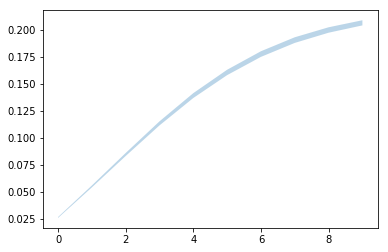

In [5]:
exp_id = "syn2.03"  # First experiment
task_id = "bounce-states"
exp_mode = "meta"
dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
filename = "Net_meta_('bounce-states',)_input_6_(100,100)_stat_8_pre_400_pool_max_context_0_hid_(40, 40, 40)_(100, 3)_(60, 3)_VAE_False_0.2_uncer_False_lr_0.0001_reg_1e-08_actgen_leakyRelu_actmodel_leakyRelu_indi_core_huber_pat_500_for_1_syn2.03_info.p"
info_dict = pickle.load(open(dirname + filename, "rb"))
master_model = load_model_dict(info_dict["model_dict"][-1])

loss_t_list = []
for task_key, task in tasks_test.items():
    ((X_train, y_train), (X_test, y_test)), info = task
    y_pred = master_model.get_predictions(X_test, X_train, y_train[:, :2], forward_steps=range(1,11))["y_pred"]
    y_pred_reshape = y_pred.view(y_pred.size(0), -1,2)
    y_test_reshape = y_test.view(y_test.size(0), -1, 2)
    loss_t = ((y_pred_reshape - y_test_reshape) ** 2).sum(-1).sqrt().mean(0)
    loss_t_list.append(loss_t)
loss_t_list_meta = torch.stack(loss_t_list)

loss_mean_meta = loss_t_list_meta.mean(0)
loss_std_meta = loss_t_list_meta.std(0)
loss_conf_meta = loss_std_meta / np.sqrt(len(tasks_test)) * 1.96
plt.fill_between(range(len(loss_mean_meta)),to_np_array(loss_mean_meta - loss_conf_meta), to_np_array(loss_mean_meta + loss_conf_meta), alpha = 0.3)
plt.show()

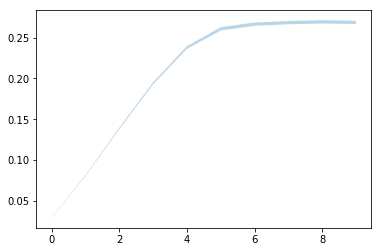

In [6]:
exp_id = "syn2.13"  # First experiment
task_id = "bounce-states"
exp_mode = "finetune"
dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
filename = "Net_finetune_('bounce-states',)_input_6_(100,100)_stat_8_pre_400_pool_max_context_0_hid_(40, 40, 40)_(100, 3)_(60, 3)_VAE_False_0.2_uncer_False_lr_0.001_reg_1e-08_actgen_leakyRelu_actmodel_leakyRelu_indi_core_huber_pat_1000_for_1_syn2.13_info.p"
info_dict = pickle.load(open(dirname + filename, "rb"))
model = load_model_dict_net(info_dict["model_dict"][-1])

loss_t_list = []
i = 0
for task_key, task in tasks.items():
    ((X_train, y_train), (X_test, y_test)), info = task
    y_pred_reshape = get_forward_pred(model, X_test, forward_steps=range(1,11))
    y_test_reshape = y_test.view(y_test.size(0), -1, 2)
    loss_t = ((y_pred_reshape - y_test_reshape) ** 2).sum(-1).sqrt().mean(0)
    loss_t_list.append(loss_t)
loss_t_list_finetune = torch.stack(loss_t_list)

loss_mean_finetune = loss_t_list_finetune.mean(0)
loss_std_finetune = loss_t_list_finetune.std(0)
loss_conf_finetune = loss_std_finetune / np.sqrt(len(tasks_test)) * 1.96
plt.fill_between(range(len(loss_mean_finetune)),to_np_array(loss_mean_finetune - loss_conf_finetune), to_np_array(loss_mean_finetune + loss_conf_finetune), alpha = 0.3)
plt.show()

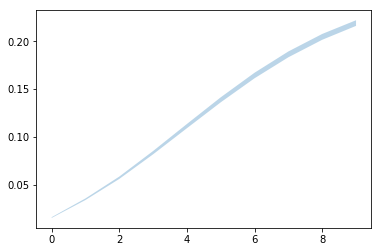

In [7]:
exp_id = "syn2.14"  # First experiment
task_id = "bounce-states"
exp_mode = "oracle"
dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
filename = "Net_oracle_('bounce-states',)_input_14_(100,100)_stat_8_pre_400_pool_max_context_0_hid_(40, 40, 40)_(100, 3)_(60, 3)_VAE_False_0.2_uncer_False_lr_0.0005_reg_1e-08_actgen_leakyRelu_actmodel_leakyRelu_indi_core_huber_pat_1000_for_1_syn2.14_info.p"
info_dict = pickle.load(open(dirname + filename, "rb"))
model = load_model_dict_net(info_dict["model_dict"][-1])

tasks_train, tasks_test = get_dataset(task_id, exp_mode, num_forward_steps=10)

loss_t_list = []
i = 0
for task_key, task in tasks_test.items():
    ((X_train, y_train), (X_test, y_test)), info = task
    y_pred_reshape = get_forward_pred(model, X_test, forward_steps=range(1,11), oracle_size = 8)
    y_test_reshape = y_test.view(y_test.size(0), -1, 2)
    loss_t = ((y_pred_reshape - y_test_reshape) ** 2).sum(-1).sqrt().mean(0)
    loss_t_list.append(loss_t)
loss_t_list_oracle = torch.stack(loss_t_list)

loss_mean_oracle = loss_t_list_oracle.mean(0)
loss_std_oracle = loss_t_list_oracle.std(0)
loss_conf_oracle = loss_std_oracle / np.sqrt(len(tasks_test)) * 1.96
plt.fill_between(range(len(loss_mean_oracle)),to_np_array(loss_mean_oracle - loss_conf_oracle), to_np_array(loss_mean_oracle + loss_conf_oracle), alpha = 0.3)
plt.show()

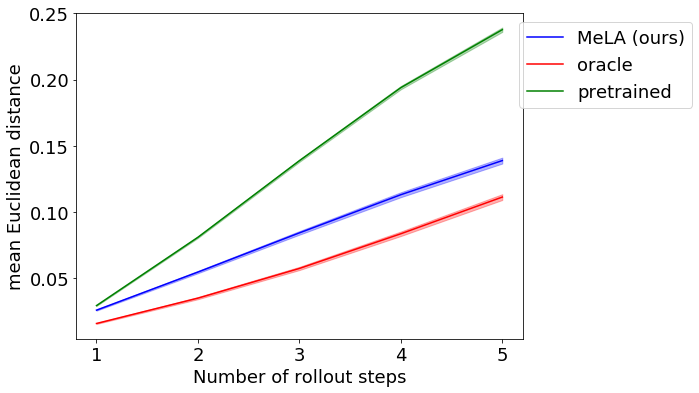

In [8]:
end = 5
plt.figure(figsize = (8,6))
plt.plot(np.arange(1,end + 1),to_np_array(loss_mean_meta)[:end], color = "b", label = "MeLA (ours)")
plt.fill_between(np.arange(1,end + 1),to_np_array(loss_mean_meta - loss_conf_meta)[:end], to_np_array(loss_mean_meta + loss_conf_meta)[:end], alpha = 0.3, color = "b")
plt.plot(np.arange(1,end + 1),to_np_array(loss_mean_oracle)[:end], color = "r", label = "oracle")
plt.fill_between(np.arange(1,end + 1),to_np_array(loss_mean_oracle - loss_conf_oracle)[:end], to_np_array(loss_mean_oracle + loss_conf_oracle)[:end], alpha = 0.3, color = "r")
plt.plot(np.arange(1,end + 1),to_np_array(loss_mean_finetune)[:end], color = "g", label = "pretrained")
plt.fill_between(np.arange(1,end + 1),to_np_array(loss_mean_finetune - loss_conf_finetune)[:end], to_np_array(loss_mean_finetune + loss_conf_finetune)[:end], alpha = 0.3, color = "g")
plt.legend(bbox_to_anchor = [0.9,0.5,.5,0.5], fontsize = 18)
plt.xlabel("Number of rollout steps", fontsize = 18)
plt.ylabel("mean Euclidean distance", fontsize = 18)
ax = plt.gca()
ax.tick_params(axis='both', labelsize = 18)
plt.savefig("fig_bouncing_states_rollout.pdf",  bbox_inches='tight')
plt.show()

## With gradient steps:

In [9]:
exp_id = "syn2.03"  # First experiment
task_id = "bounce-states"
exp_mode = "meta"
tasks_train, tasks_test = get_dataset(task_id, exp_mode, num_test_tasks = 1000, num_forward_steps=10)
task_key = 'bounce-states_101'
task = tasks_test[task_key]
print(info)

tasks = tasks_test

{'z': array([ 5.898922  ,  3.22123697, 24.05503583,  3.26082433, 27.04725049,
       34.71662945, 14.19556265, 35.33500646])}


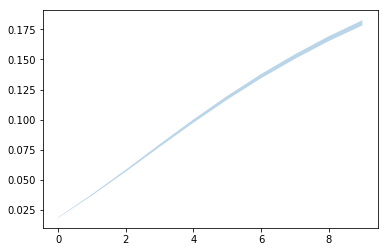

In [10]:
num_gradient_steps = 5

exp_id = "syn2.03"  # First experiment
task_id = "bounce-states"
exp_mode = "meta"
dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
filename = "Net_meta_('bounce-states',)_input_6_(100,100)_stat_8_pre_400_pool_max_context_0_hid_(40, 40, 40)_(100, 3)_(60, 3)_VAE_False_0.2_uncer_False_lr_0.0001_reg_1e-08_actgen_leakyRelu_actmodel_leakyRelu_indi_core_huber_pat_500_for_1_syn2.03_info.p"
info_dict = pickle.load(open(dirname + filename, "rb"))
master_model = load_model_dict(info_dict["model_dict"][-1])

loss_t_list = []
for task_key, task in tasks_test.items():
    ((X_train, y_train), (X_test, y_test)), info = task
    
    mse_list, new_model = quick_learn(master_model.get_clone_net(X_train, y_train[:,:2]), X_train, y_train[:,:2], validation_data = (X_test, y_test[:,:2]), forward_steps = [1], is_time_series = True, loss_core = "huber", 
                                       batch_size = 128, epochs = num_gradient_steps, lr = 1e-3, optim_type = "adam")
    y_pred_reshape = get_forward_pred(new_model, X_test, forward_steps=range(1,11))
#     y_pred = master_model.get_predictions(X_test, X_train, y_train[:, :2], forward_steps=range(1,11))["y_pred"]
#     y_pred_reshape = y_pred.view(y_pred.size(0), -1,2)
    y_test_reshape = y_test.view(y_test.size(0), -1, 2)
    loss_t = ((y_pred_reshape - y_test_reshape) ** 2).sum(-1).sqrt().mean(0)
    loss_t_list.append(loss_t)
loss_t_list_meta2 = torch.stack(loss_t_list)

loss_mean_meta2 = loss_t_list_meta2.mean(0)
loss_std_meta2 = loss_t_list_meta2.std(0)
loss_conf_meta2 = loss_std_meta2 / np.sqrt(len(tasks_test)) * 1.96
plt.fill_between(range(len(loss_mean_meta2)),to_np_array(loss_mean_meta2 - loss_conf_meta2), to_np_array(loss_mean_meta2 + loss_conf_meta2), alpha = 0.3)
plt.show()

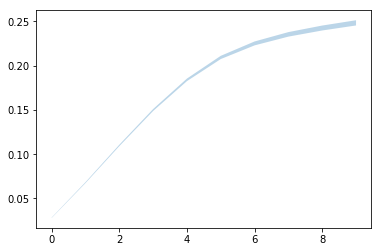

In [11]:
exp_id = "syn2.13"  # First experiment
task_id = "bounce-states"
exp_mode = "finetune"
dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
filename = "Net_finetune_('bounce-states',)_input_6_(100,100)_stat_8_pre_400_pool_max_context_0_hid_(40, 40, 40)_(100, 3)_(60, 3)_VAE_False_0.2_uncer_False_lr_0.001_reg_1e-08_actgen_leakyRelu_actmodel_leakyRelu_indi_core_huber_pat_1000_for_1_syn2.13_info.p"
info_dict = pickle.load(open(dirname + filename, "rb"))
model = load_model_dict_net(info_dict["model_dict"][-1])

loss_t_list = []
i = 0
for task_key, task in tasks.items():
    ((X_train, y_train), (X_test, y_test)), info = task
    mse_list, new_model = quick_learn(model, X_train, y_train[:,:2], validation_data = (X_test, y_test[:,:2]), forward_steps = [1], is_time_series = True, loss_core = "huber", 
                                       batch_size = 128, epochs = num_gradient_steps, lr = 1e-3, optim_type = "adam")
    y_pred_reshape = get_forward_pred(new_model, X_test, forward_steps=range(1,11))
    y_test_reshape = y_test.view(y_test.size(0), -1, 2)
    loss_t = ((y_pred_reshape - y_test_reshape) ** 2).sum(-1).sqrt().mean(0)
    loss_t_list.append(loss_t)
loss_t_list_finetune2 = torch.stack(loss_t_list)

loss_mean_finetune2 = loss_t_list_finetune2.mean(0)
loss_std_finetune2 = loss_t_list_finetune2.std(0)
loss_conf_finetune2 = loss_std_finetune2 / np.sqrt(len(tasks_test)) * 1.96
plt.fill_between(range(len(loss_mean_finetune2)),to_np_array(loss_mean_finetune2 - loss_conf_finetune2), to_np_array(loss_mean_finetune2 + loss_conf_finetune2), alpha = 0.3)
plt.show()

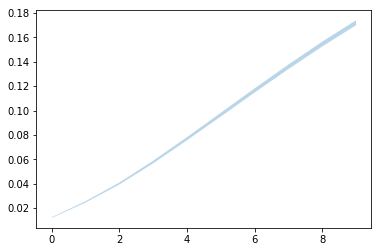

In [12]:
exp_id = "syn2.14"  # First experiment
task_id = "bounce-states"
exp_mode = "oracle"
dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
filename = "Net_oracle_('bounce-states',)_input_14_(100,100)_stat_8_pre_400_pool_max_context_0_hid_(40, 40, 40)_(100, 3)_(60, 3)_VAE_False_0.2_uncer_False_lr_0.0005_reg_1e-08_actgen_leakyRelu_actmodel_leakyRelu_indi_core_huber_pat_1000_for_1_syn2.14_info.p"
info_dict = pickle.load(open(dirname + filename, "rb"))
model = load_model_dict_net(info_dict["model_dict"][-1])

tasks_train, tasks_test = get_dataset(task_id, exp_mode, num_forward_steps=10)

loss_t_list = []
i = 0
for task_key, task in tasks_test.items():
    ((X_train, y_train), (X_test, y_test)), info = task
    mse_list, new_model = quick_learn(model, X_train, y_train[:,:2], validation_data = (X_test, y_test[:,:2]), forward_steps = [1], is_time_series = True, loss_core = "huber", 
                                       batch_size = 128, epochs = num_gradient_steps, lr = 2e-4, optim_type = "adam")
    y_pred_reshape = get_forward_pred(new_model, X_test, forward_steps=range(1,11), oracle_size = 8)
    y_test_reshape = y_test.view(y_test.size(0), -1, 2)
    loss_t = ((y_pred_reshape - y_test_reshape) ** 2).sum(-1).sqrt().mean(0)
    loss_t_list.append(loss_t)
loss_t_list_oracle2 = torch.stack(loss_t_list)

loss_mean_oracle2 = loss_t_list_oracle2.mean(0)
loss_std_oracle2 = loss_t_list_oracle2.std(0)
loss_conf_oracle2 = loss_std_oracle2 / np.sqrt(len(tasks_test)) * 1.96
plt.fill_between(range(len(loss_mean_oracle2)),to_np_array(loss_mean_oracle2 - loss_conf_oracle2), to_np_array(loss_mean_oracle2 + loss_conf_oracle2), alpha = 0.3)
plt.show()

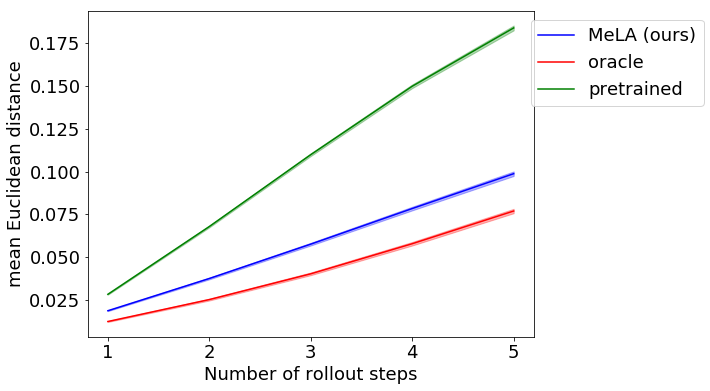

In [13]:
end = 5
plt.figure(figsize = (8,6))
plt.plot(np.arange(1,end + 1),to_np_array(loss_mean_meta2)[:end], color = "b", label = "MeLA (ours)")
plt.fill_between(np.arange(1,end + 1),to_np_array(loss_mean_meta2 - loss_conf_meta2)[:end], to_np_array(loss_mean_meta2 + loss_conf_meta2)[:end], alpha = 0.3, color = "b")
plt.plot(np.arange(1,end + 1),to_np_array(loss_mean_oracle2)[:end], color = "r", label = "oracle")
plt.fill_between(np.arange(1,end + 1),to_np_array(loss_mean_oracle2 - loss_conf_oracle2)[:end], to_np_array(loss_mean_oracle2 + loss_conf_oracle2)[:end], alpha = 0.3, color = "r")
plt.plot(np.arange(1,end + 1),to_np_array(loss_mean_finetune2)[:end], color = "g", label = "pretrained")
plt.fill_between(np.arange(1,end + 1),to_np_array(loss_mean_finetune2 - loss_conf_finetune2)[:end], to_np_array(loss_mean_finetune2 + loss_conf_finetune2)[:end], alpha = 0.3, color = "g")
plt.legend(bbox_to_anchor = [0.9,0.5,.5,0.5], fontsize = 18)
plt.xlabel("Number of rollout steps", fontsize = 18)
plt.ylabel("mean Euclidean distance", fontsize = 18)
ax = plt.gca()
ax.tick_params(axis='both', labelsize = 18)
plt.savefig("fig_bouncing_states_rollout.pdf",  bbox_inches='tight')
plt.show()

## Combined:

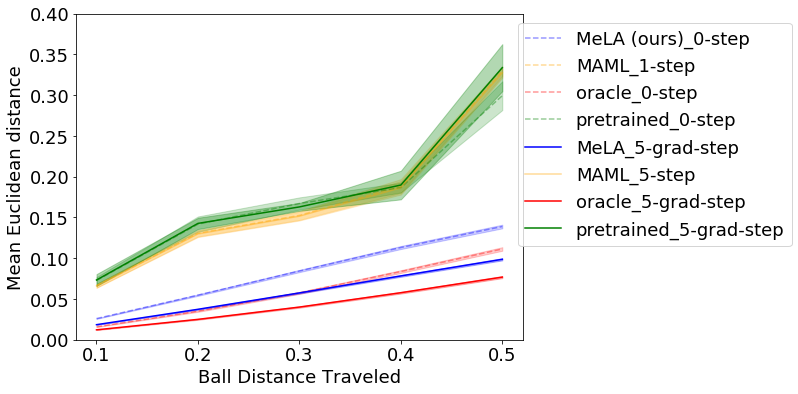

In [40]:
end = 5
x_axis = np.arange(1,end + 1) * 0.1
plt.figure(figsize = (8,6))
alpha10 = 0.4
alpha1 = 0.2
plt.plot(x_axis ,to_np_array(loss_mean_meta)[:end], color = "b", label = "MeLA (ours)_0-step", alpha = alpha10, linestyle = "--")
plt.fill_between(x_axis,to_np_array(loss_mean_meta - loss_conf_meta)[:end], to_np_array(loss_mean_meta + loss_conf_meta)[:end], alpha = alpha1, color = "b")
plt.plot(x_axis ,loss_mean_maml[:end], color = "orange", label = "MAML_1-step", alpha = alpha10, linestyle = "--")
plt.fill_between(x_axis,(loss_mean_maml - loss_conf_maml)[:end], (loss_mean_maml + loss_conf_maml)[:end], alpha = alpha1, color = "orange")
plt.plot(x_axis,to_np_array(loss_mean_oracle)[:end], color = "r", label = "oracle_0-step", alpha = alpha10, linestyle = "--")
plt.fill_between(x_axis,to_np_array(loss_mean_oracle - loss_conf_oracle)[:end], to_np_array(loss_mean_oracle + loss_conf_oracle)[:end], alpha = alpha1, color = "r")
plt.plot(x_axis,(loss_mean_finetune)[:end], color = "g", label = "pretrained_0-step", alpha = alpha10, linestyle = "--")
plt.fill_between(x_axis,(loss_mean_finetune - loss_conf_finetune)[:end], (loss_mean_finetune + loss_conf_finetune)[:end], alpha = alpha1, color = "g")
plt.legend(bbox_to_anchor = [0.9,0.5,.5,0.5], fontsize = 18)
plt.xlabel("Ball Distance Traveled", fontsize = 18)
plt.ylabel("Mean Euclidean distance", fontsize = 18)
# ax = plt.gca()
# ax.tick_params(axis='both', labelsize = 18)
# plt.savefig("fig_bouncing_states_rollout.pdf",  bbox_inches='tight')
# plt.show()


end = 5
# plt.figure(figsize = (8,6))
plt.plot(x_axis ,to_np_array(loss_mean_meta2)[:end], color = "b", label = "MeLA_5-grad-step")
plt.fill_between(x_axis ,to_np_array(loss_mean_meta2 - loss_conf_meta2)[:end], to_np_array(loss_mean_meta2 + loss_conf_meta2)[:end], alpha = 0.3, color = "b")
plt.plot(x_axis ,loss_mean_maml2[:end], color = "orange", label = "MAML_5-step", alpha = alpha10, linestyle = "-")
plt.fill_between(x_axis,(loss_mean_maml2 - loss_conf_maml2)[:end], (loss_mean_maml2 + loss_conf_maml2)[:end], alpha = alpha1, color = "orange")
plt.plot(x_axis ,to_np_array(loss_mean_oracle2)[:end], color = "r", label = "oracle_5-grad-step")
plt.fill_between(x_axis ,to_np_array(loss_mean_oracle2 - loss_conf_oracle2)[:end], to_np_array(loss_mean_oracle2 + loss_conf_oracle2)[:end], alpha = 0.3, color = "r")
plt.plot(x_axis ,(loss_mean_finetune2)[:end], color = "g", label = "pretrained_5-grad-step")
plt.fill_between(x_axis ,(loss_mean_finetune2 - loss_conf_finetune2)[:end], (loss_mean_finetune2 + loss_conf_finetune2)[:end], alpha = 0.3, color = "g")
plt.legend(bbox_to_anchor = [0.97,0.5,.5,0.5], fontsize = 18)
# plt.xlabel("Number of rollout steps", fontsize = 18)
# plt.ylabel("mean Euclidean distance", fontsize = 18)
ax = plt.gca()
plt.ylim([0,0.4])
ax.tick_params(axis='both', labelsize = 18)
plt.savefig("fig_bouncing_states_rollout.pdf",  bbox_inches='tight')
plt.show()

In [34]:
loss_mean_maml2 = AA[:,0]
loss_conf_maml2 = AA[:,1] / np.sqrt(10)
loss_mean_maml = AA[:,4]
loss_conf_maml = AA[:,5] / np.sqrt(10)
loss_mean_finetune2 = AA[:,2]
loss_conf_finetune2 = AA[:,3]

In [16]:
AA = np.loadtxt("final_ball_states.csv", delimiter=",")

## Visualize:

In [4]:
exp_id = "syn2.03"  # First experiment
task_id = "bounce-states"
exp_mode = "meta"
dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
filename = "Net_meta_('bounce-states',)_input_6_(100,100)_stat_8_pre_400_pool_max_context_0_hid_(40, 40, 40)_(100, 3)_(60, 3)_VAE_False_0.2_uncer_False_lr_0.0001_reg_1e-08_actgen_leakyRelu_actmodel_leakyRelu_indi_core_huber_pat_500_for_1_syn2.03_info.p"
info_dict = pickle.load(open(dirname + filename, "rb"))
master_model = load_model_dict(info_dict["model_dict"][-1])

In [6]:
exp_id = "syn2.03"  # First experiment
task_id = "bounce-states"
exp_mode = "meta"
tasks_train, tasks_test = get_dataset(task_id, exp_mode, num_test_tasks = 1000, num_forward_steps=1)
task_key = 'bounce-states_101'
task = tasks_test[task_key]

tasks = tasks_test
((X_train, y_train), (X_test, y_test)), info = task

In [56]:
def visualize(task_key, num_examples_show = 10, highlight_top = 10, alpha_main = 0.8, alpha_highlight = 0.5, ):
    tasks = tasks_test
    
    
#     master_model = master_model
    model = None
    autoencoder = None
    num_shots = None
    
    valid_input_dims = None
    target_forward_steps = 1
    eval_forward_steps = 1
    kwargs = {}


    import matplotlib.pylab as plt
    fig = plt.figure(figsize = (8,6))
    # plt.subplots_adjust(hspace = 0.4)


    # for k, task_key in enumerate(tasks_key_show):
    if autoencoder is not None:
        forward_steps = list(range(1, eval_forward_steps + 1))
        forward_steps_idx = torch.LongTensor(np.array(forward_steps) - 1)
        if autoencoder.is_cuda:
            forward_steps_idx = forward_steps_idx.cuda()
        ((X_train_obs, y_train_obs), (X_test_obs, y_test_obs)), _ = tasks[task_key]
        X_train = forward(autoencoder.encode, X_train_obs)
        y_train = forward(autoencoder.encode, y_train_obs[:, forward_steps_idx])
        X_test = forward(autoencoder.encode, X_test_obs)
        y_test = forward(autoencoder.encode, y_test_obs[:, forward_steps_idx])
    else:
        ((X_train, y_train), (X_test, y_test)), _ = tasks[task_key]
    num_steps = int(X_test.size(1) / 2)
    is_cuda = X_train.is_cuda
    X_test_numpy, y_test_numpy = to_np_array(X_test, y_test)
    if len(X_test_numpy.shape) == 2:
        X_test_numpy = X_test_numpy.reshape(-1, num_steps, 2)
        y_test_numpy = y_test_numpy.reshape(-1, int(y_test_numpy.shape[1] / 2), 2)

    # Get highlighted examples:
    if highlight_top is not None:
        relevance_train = get_relevance(X_train, y_train[:,:2], master_model.statistics_Net)
        X_sorted, y_sorted, relevance_sorted = sort_datapoints(X_train, y_train, relevance_train, top = highlight_top)
        if len(X_sorted.shape) == 2:
            X_sorted = X_sorted.view(-1, num_steps, 2)
            y_sorted = y_sorted.view(-1, int(y_sorted.shape[1] / 2), 2)
        X_sorted, y_sorted = to_np_array(X_sorted, y_sorted)

    # Get model prediction:
    if master_model is not None:
        if num_shots is None:
            statistics = master_model.statistics_Net.forward_inputs(X_train, y_train[:, :target_forward_steps * 2])
        else:
            idx = torch.LongTensor(np.random.choice(range(len(X_train)), min(len(X_train), num_shots), replace = False))
            if is_cuda:
                idx = idx.cuda()
            statistics = master_model.statistics_Net.forward_inputs(X_train[idx], y_train[idx, :target_forward_steps * 2])
        if isinstance(statistics, tuple):
            statistics = statistics[0]

        master_model.generative_Net.set_latent_param(statistics)
        model_core = master_model.generative_Net

        # Prediction for highlighted examples:
        if highlight_top is not None:
            y_sorted_pred = model_core(to_Variable(X_sorted.reshape(X_sorted.shape[0], -1), is_cuda = is_cuda))
            y_sorted_pred = to_np_array(y_sorted_pred)
            if len(y_sorted_pred.shape) == 2:
                y_sorted_pred = y_sorted_pred.reshape(-1, int(y_sorted_pred.shape[1] / 2), 2)
    else:
        assert model is not None
        model_core = model

    preds = predict_forward(model_core, X_test, num_forward_steps = eval_forward_steps)
    y_pred_numpy = to_np_array(reshape_time_series(preds))

    # Plotting:
    # ax = fig.add_subplot(int(np.ceil(num_tasks_show / float(3))), 3, k + 1)
    ax = plt.gca()
    for i in range(len(X_test_numpy)):
        if i >= num_examples_show:
            break
        x_ele = X_test_numpy[i]
        if valid_input_dims is not None:
            x_ele = x_ele[:int(valid_input_dims / 2), :]
        y_ele = y_test_numpy[i]
        if i == 0:
            ax.plot(x_ele[:,0], x_ele[:,1], ".-", color = "r", alpha = alpha_main, zorder = -1, label = "3-step inputs")
        else:
            ax.plot(x_ele[:,0], x_ele[:,1], ".-", color = "r", alpha = alpha_main, zorder = -1)
        # Target:
        if i == 0:
            ax.plot(np.concatenate((x_ele[:,0][-1:], y_ele[:,0])), np.concatenate((x_ele[:,1][-1:], y_ele[:,1])), ".--", alpha = alpha_main, color = "r", zorder = -1, label = "Target")
        else:
            ax.plot(np.concatenate((x_ele[:,0][-1:], y_ele[:,0])), np.concatenate((x_ele[:,1][-1:], y_ele[:,1])), ".--", alpha = alpha_main, color = "r", zorder = -1)
        ax.scatter(y_ele[:,0], y_ele[:,1], s = np.linspace(10, 20, len(y_ele[:,0])), marker = "o", color = "r", zorder = 2)
    #         ax.set_title(task_key)
        if master_model is not None or model is not None:
            y_pred_ele = y_pred_numpy[i]
            if i ==0:
                ax.plot(np.concatenate((x_ele[:,0][-1:], y_pred_ele[:,0])), np.concatenate((x_ele[:,1][-1:], y_pred_ele[:,1])), "--", color = "b", zorder = -1, label = "MeLA prediction")
            else:
                ax.plot(np.concatenate((x_ele[:,0][-1:], y_pred_ele[:,0])), np.concatenate((x_ele[:,1][-1:], y_pred_ele[:,1])), "--", color = "b", zorder = -1)
            
            ax.scatter(y_pred_ele[:,0], y_pred_ele[:,1], s = np.linspace(10, 20, len(y_ele[:,0])), marker = "o", color = "b", zorder = 2)

    # Plotting highlighted examples:
    if highlight_top is not None:
        for i in range(highlight_top):
            x_ele = X_sorted[i]
            y_ele = y_sorted[i]
            if i == 0:
                ax.plot(x_ele[:,0], x_ele[:,1], "^-", color = "k", zorder = -1, alpha = alpha_highlight,label = "Influential training examples")
            else:
                ax.plot(x_ele[:,0], x_ele[:,1], "^-", color = "k", zorder = -1, alpha = alpha_highlight)
            if i == 0:
                ax.plot(np.concatenate((x_ele[:,0][-1:], y_ele[:,0])), np.concatenate((x_ele[:,1][-1:], y_ele[:,1])), "^--", color = "k", alpha = alpha_highlight, zorder = -1)
            else:
                ax.plot(np.concatenate((x_ele[:,0][-1:], y_ele[:,0])), np.concatenate((x_ele[:,1][-1:], y_ele[:,1])), "^--", color = "k", alpha = alpha_highlight, zorder = -1)
            
    #             ax.scatter(y_ele[:,0], y_ele[:,1], s = np.linspace(10, 20, len(y_ele[:,0])), marker = "o", color = "r", zorder = 2)
    #             ax.set_title(task_key)
            if master_model is not None or model is not None:
                y_pred_ele = y_sorted_pred[i]
    #                 ax.plot(np.concatenate((x_ele[:,0], y_pred_ele[:,0])), np.concatenate((x_ele[:,1], y_pred_ele[:,1])), ".--", alpha = 0.8, color = "k", zorder = -1)
    #             ax.scatter(y_pred_ele[:,0], y_pred_ele[:,1], s = np.linspace(10, 20, len(y_ele[:,0])), marker = "o", color = "k", alpha = 0.8, zorder = 2)

    plt.xlim([0.1,0.9])
    plt.ylim([0.1,0.9])
    plt.plot(z1[:,0], z1[:,1], color = "g", alpha = 0.3, label = "hidden walls")
    plt.plot(np.concatenate((z1[-1:,0],z1[:1,0])),np.concatenate((z1[-1:,1],z1[:1,1])), color = "g", alpha = 0.3)
#     plt.legend()
    plt.legend(bbox_to_anchor = [0.85,0.5,.5,0.5], fontsize = 18)
    # plt.xlabel("Number of rollout steps", fontsize = 18)
    # plt.ylabel("mean Euclidean distance", fontsize = 18)
    ax = plt.gca()
    ax.tick_params(axis='both', labelsize = 18)
    plt.savefig("fig_bouncing_states_visualize.pdf",  bbox_inches='tight')
    plt.show()

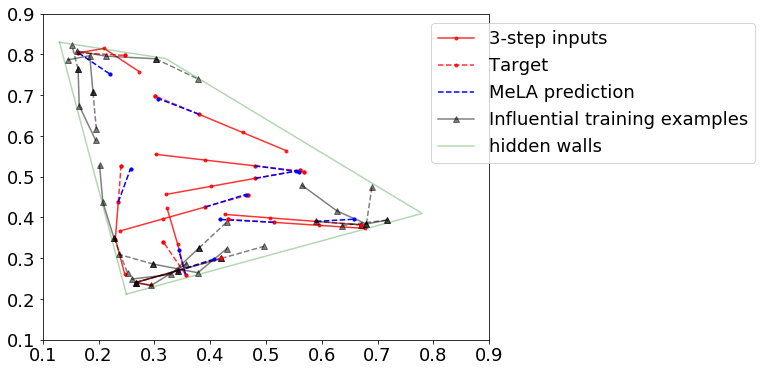

In [60]:
z1 = np.array([[0.25,0.212],
       [0.78, 0.41],
       [0.32,0.79],
       [0.13, 0.83]])
visualize("bounce-states_115", 10, 10)

## bounce-states exp:

In [78]:
colors = {"meta": "b",
          "maml": "orange",
          "oracle": "r",
          "finetune": "g"}
labels = {"meta": "MeLA (ours)",
          "maml": "MAML",
          "oracle": "oracle",
          "finetune": "pretrained",
         }
keys = ["meta", "oracle", "finetune"]

In [79]:
# For meta:
exp_id = "syn2.03"  # First experiment
task_id = "bounce-states"
exp_mode = "meta"
dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
filename = "Net_meta_('bounce-states',)_input_6_(100,100)_stat_8_pre_400_pool_max_context_0_hid_(40, 40, 40)_(100, 3)_(60, 3)_VAE_False_0.2_uncer_False_lr_0.0001_reg_1e-08_actgen_leakyRelu_actmodel_leakyRelu_indi_core_huber_pat_500_for_1_syn2.03_info.p"
info_dict = pickle.load(open(dirname + filename, "rb"))
models = {}
models["meta"] = load_model_dict(info_dict["model_dict"][-1])
mse_test_meta = np.array(info_dict["mse_test_lr_0.001"])

exp_id = "syn2.13"  # First experiment
task_id = "bounce-states"
exp_mode = "finetune"
dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
filename = "Net_finetune_('bounce-states',)_input_6_(100,100)_stat_8_pre_400_pool_max_context_0_hid_(40, 40, 40)_(100, 3)_(60, 3)_VAE_False_0.2_uncer_False_lr_0.001_reg_1e-08_actgen_leakyRelu_actmodel_leakyRelu_indi_core_huber_pat_1000_for_1_syn2.13_info.p"
info_dict = pickle.load(open(dirname + filename, "rb"))
models = {}
models["finetune"] = load_model_dict_net(info_dict["model_dict"][-1])
mse_test_finetune = np.array(info_dict["mse_test_lr_0.001"])

# # For finetune:
# exp_id = "syn1.11"  # First experiment
# task_id = "C-sin"
# exp_mode = "finetune"
# dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
# filename = "Net_finetune_('C-sin',)_input_1_(100,100)_stat_2_pre_200_pool_max_context_0_hid_(40, 40)_(120, 3)_(60, 3)_VAE_False_0.2_uncer_False_lr_0.0005_reg_1e-06_actgen_leakyRelu_actmodel_leakyRelu_indi_core_huber_pat_400_for_1_syn1.11_info.p"
# info_dict = pickle.load(open(dirname + filename, "rb"))
# models["finetune"] = load_model_dict_net(info_dict["model_dict"][-1])
# mse_test_finetune = np.array(info_dict["mse_test_lr_0.001"])

# For oracle:
exp_id = "syn2.14"  # First experiment
task_id = "bounce-states"
exp_mode = "oracle"
dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
filename = "Net_oracle_('bounce-states',)_input_14_(100,100)_stat_8_pre_400_pool_max_context_0_hid_(40, 40, 40)_(100, 3)_(60, 3)_VAE_False_0.2_uncer_False_lr_0.0005_reg_1e-08_actgen_leakyRelu_actmodel_leakyRelu_indi_core_huber_pat_500_for_1_syn2.14_info.p"
info_dict = pickle.load(open(dirname + filename, "rb"))
mse_test_oracle = np.array(info_dict["mse_test_lr_0.0002"])

# # maml:
# maml = np.loadtxt(open(variational_model_PATH + "/trained_models/" +  "{0}_maml.csv".format(task_id), "rb"), delimiter=",", skiprows=1)

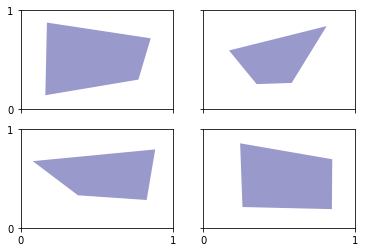

In [73]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')

ax = [ax1,ax2,ax3,ax4]


num_polygons = 5
num_sides = 5

screen_size = 39
ball_radius = 3


for i in range(4):
    patches = []
    vertex0 = np.array(np.random.rand(2) * screen_size / 3 + ball_radius)
    vertex1 = np.array((screen_size - np.random.rand() * screen_size / 3 - ball_radius, np.random.rand() * screen_size / 3 + ball_radius))
    vertex2 = np.array((screen_size - np.random.rand(2) * screen_size / 3 - ball_radius))
    vertex3 = np.array((np.random.rand() * screen_size / 3 + ball_radius, screen_size - np.random.rand() * screen_size / 3 - ball_radius))
    vertices = np.stack([vertex0, vertex1, vertex2,vertex3]) * 0.025

    polygon = Polygon(vertices, True)
    patches.append(polygon)

    p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)

    colors = 100*np.random.rand(len(patches))
    p.set_array(np.array(colors))

    ax[i].add_collection(p)
    ax[i].set_xticks(np.arange(0,2, 1))
    ax[i].set_yticks(np.arange(0,2, 1))
f.savefig("fig_bouncing_states_show.pdf",  bbox_inches='tight')
# plt.show()

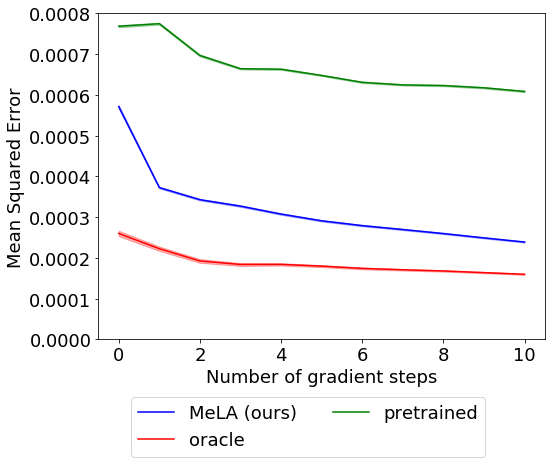

In [80]:
mse_list_all = mse_test_meta
num_tasks_test = 20000
Dict = OrderedDict()
Dict["meta"] = [mse_test_meta.mean(0), mse_test_meta.std(0) * 1.96 / np.sqrt(int(num_tasks_test / 100))]
Dict["finetune"] = [mse_test_finetune.mean(0), mse_test_finetune.std(0) * 1.96 / np.sqrt(int(num_tasks_test / 100))]
Dict["oracle"] = [mse_test_oracle.mean(0), mse_test_oracle.std(0) * 1.96 / np.sqrt(int(num_tasks_test / 100))]
# Dict["maml"] = [maml[:,1], maml[:,2]]

plt.figure(figsize = (8,6))
begin = 0
end = 11
for i, key in enumerate(keys):
    (mse_mean, mse_conf) = Dict[key]
    mse_mean = mse_mean[begin:end]
    mse_conf = mse_conf[begin:end]
    plt.fill_between(range(len(mse_mean)), mse_mean - mse_conf, mse_mean + mse_conf, alpha = 0.3, color = colors[key])
    plt.plot(range(len(mse_mean)), mse_mean, label = labels[key], color = colors[key])
    plt.xlabel("Number of gradient steps", fontsize = 18)
    plt.ylabel("Mean Squared Error", fontsize = 18)
# plt.legend(fontsize = 18)
plt.legend(fontsize = 18, bbox_to_anchor = [0.22,-0.65, 0.5, 0.5], loc=9,ncol=2)
plt.ylim([0,0.0008])
ax = plt.gca()
ax.tick_params(axis='both', labelsize = 18)
plt.savefig("fig_bouncing_states_quicklearn.pdf",  bbox_inches='tight')
plt.show()